# Phase 7: Comprehensive Model Evaluation

In this notebook, we perform a deep-dive evaluation of our Champion Model. We look beyond accuracy to understand the business impact of our predictions.

### 1. Setup & Load Champion Model

In [1]:
import pandas as pd
import joblib
import sys
import os

# Add src to path
sys.path.append(os.path.abspath('..'))
from src.config import PROCESSED_DATA_DIR, MODELS_DIR
from src.model_evaluation import (
    get_comprehensive_metrics, plot_confusion_matrix_custom, 
    plot_roc_pr_curves, find_optimal_threshold, analyze_misclassifications
)

# Load Data
X_test = pd.read_csv(PROCESSED_DATA_DIR / 'X_test.csv')
y_test = pd.read_csv(PROCESSED_DATA_DIR / 'y_test.csv').values.ravel()

# Load Champion Model (Ensure you saved it in the previous step!)
# Replace 'xgboost_champion.joblib' with your actual filename if different
model = joblib.load(MODELS_DIR / 'xgboost_champion.joblib')
print(f"Loaded Model: {type(model).__name__}")

Loaded Model: XGBClassifier


### 2. Standard Performance Metrics

,Champion Model
Accuracy,0.753025
Precision,0.522936
Recall,0.766129
F1 Score,0.621592
AUC-ROC,0.842927


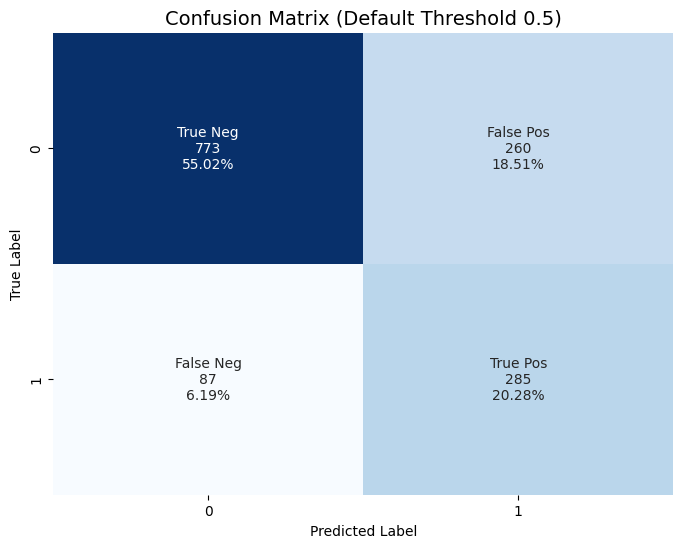

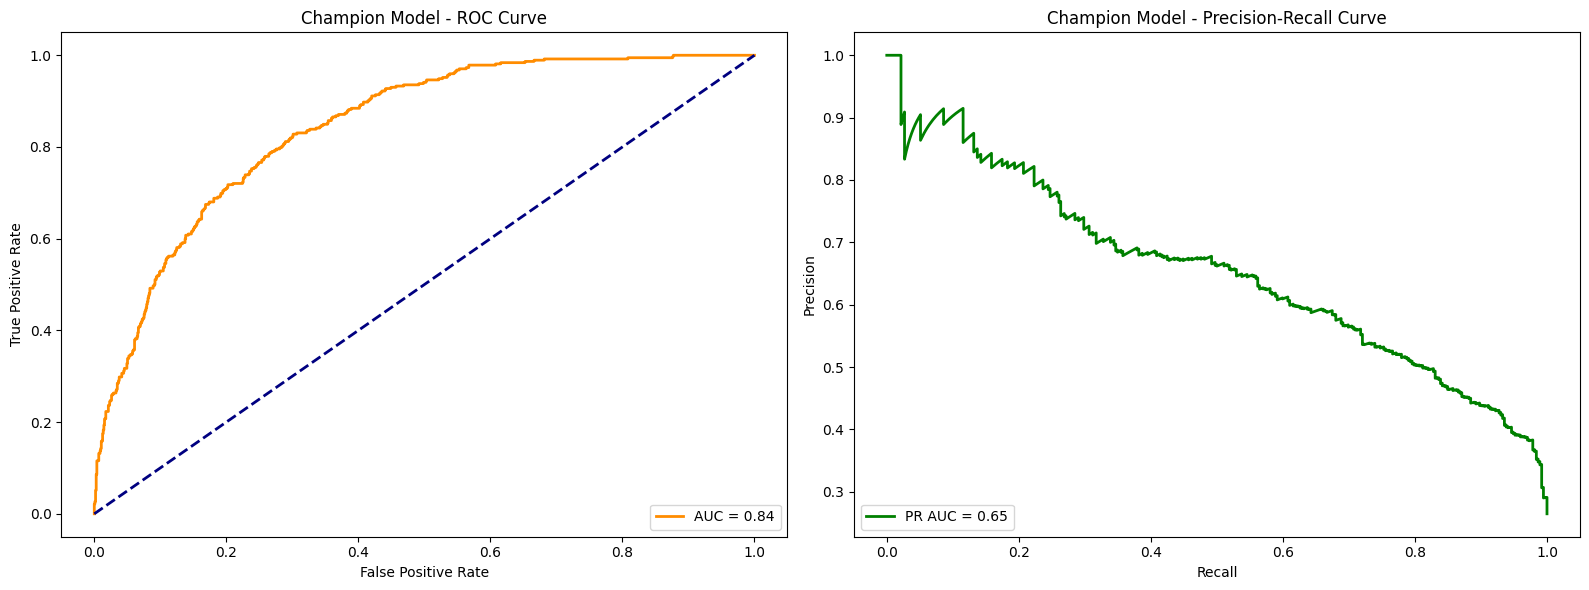

In [2]:
# Get predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate Metrics
metrics = get_comprehensive_metrics(y_test, y_pred, y_prob)
display(pd.DataFrame(metrics, index=['Champion Model']).T)

# Visuals
plot_confusion_matrix_custom(y_test, y_pred, title="Confusion Matrix (Default Threshold 0.5)")
plot_roc_pr_curves(y_test, y_prob, model_name="Champion Model")

### 3. Threshold Optimization
By default, the model predicts "Churn" if probability > 50%. 
However, if we want to catch *more* churners (Recall), we should lower this threshold.
Let's find the mathematical "Sweet Spot" that maximizes the F1-Score.

Best Threshold: 0.6167
Best F1 Score: 0.6299


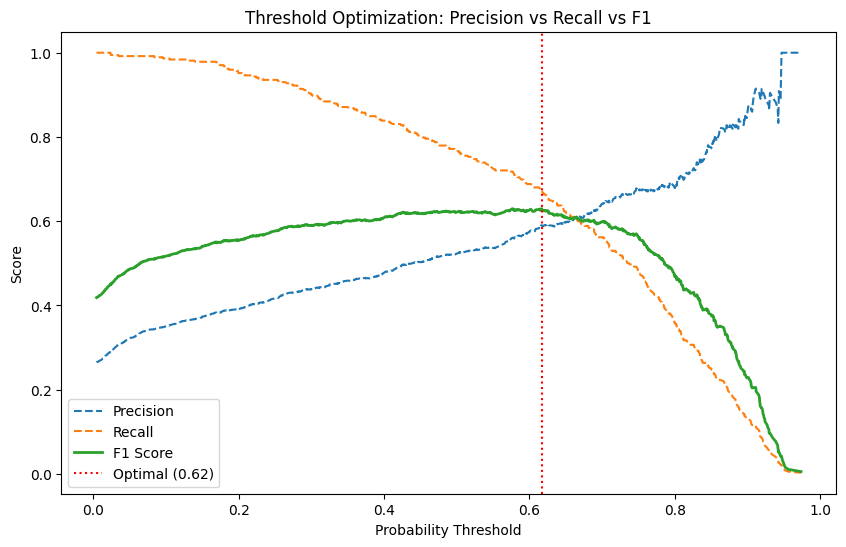

Impact of Threshold Optimization:


,Accuracy,Precision,Recall,F1 Score,AUC-ROC
Default (0.5),0.753025,0.522936,0.766129,0.621592,0.842927
Optimized (0.62),0.790036,0.590588,0.674731,0.629862,0.842927


In [3]:
# Find best threshold
best_thresh = find_optimal_threshold(y_test, y_prob)

# Apply new threshold
y_pred_optimized = (y_prob >= best_thresh).astype(int)

# Compare Results
metrics_opt = get_comprehensive_metrics(y_test, y_pred_optimized, y_prob)
comparison = pd.DataFrame([metrics, metrics_opt], index=['Default (0.5)', f'Optimized ({best_thresh:.2f})'])

print("Impact of Threshold Optimization:")
display(comparison)

### 4. Error Analysis (The "Why")
We need to understand **who** the model is missing.
Let's look at the **False Negatives** (People who churned, but the model thought they would stay).

In [4]:
# Extract False Negatives
fn_df = analyze_misclassifications(model, X_test, y_test, y_pred)

print(f"Number of False Negatives: {len(fn_df)}")
print("Sample of Missed Churners:")
display(fn_df.head())

# Analyze numerical traits of missed churners
# (We look at the scaled values here, but in a real report, you'd unscale them)
print("\nStats of Missed Churners (False Negatives):")
print(fn_df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

Number of False Negatives: 87
Sample of Missed Churners:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Actual,Predicted
12,0,6.0,49.65,267.35,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,1,0
29,0,11.0,19.25,180.30,False,True,True,True,False,False,...,True,False,False,False,True,False,False,True,1,0
41,0,9.0,40.65,328.95,True,True,False,False,True,False,...,False,False,False,False,False,False,False,True,1,0
91,1,8.0,19.65,164.30,False,False,False,True,False,False,...,True,False,False,False,False,False,True,False,1,0
98,0,32.0,84.05,2781.85,False,False,False,True,False,True,...,False,False,True,False,False,False,True,False,1,0



Stats of Missed Churners (False Negatives):
          tenure  MonthlyCharges  TotalCharges
count  87.000000       87.000000     87.000000
mean   29.586207       61.535632   2224.840230
std    21.056707       28.839715   2084.440818
min     1.000000       19.250000     19.300000
25%    10.500000       42.425000    344.900000
50%    24.000000       55.950000   1380.100000
75%    47.000000       85.325000   3639.725000
max    71.000000      113.150000   7856.000000


**Insight from Error Analysis:**
*Are the missed churners mostly new customers? Or are they long-tenure customers who had a sudden bad experience?* (Add your observation here. For example: "The model struggles to predict churn for high-tenure customers, likely because their historical behavior looks very stable.")